In [1]:
%matplotlib inline

from pathlib import Path
import json
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tqdm
import skimage
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skimage')

from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log

root_dir = Path("/home/hadim/.data/Neural_Network/Mask-RCNN/Microtubules/")

data_dir = root_dir / "data"
data_dir.mkdir(parents=True, exist_ok=True)

model_dir = root_dir / "logs"
model_dir.mkdir(parents=True, exist_ok=True)

coco_model_path = root_dir / "mask_rcnn_coco.h5"
if not coco_model_path.is_file():
    utils.download_trained_weights(str(coco_model_path))
    
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Using TensorFlow backend.


In [9]:
class MicrotubuleDataset(utils.Dataset):

    def load_microtubules(self, fnames, line_thickness=4, verbose=False):
        self.add_class("microtubule", 1, "microtubule")
        
        for i, fname in tqdm.tqdm(enumerate(fnames), total=len(fnames), disable=not verbose, leave=False):
            im = skimage.io.imread(fname)
            self.add_image("microtubule", image_id=i, path=fname,
                           width=im.shape[0], height=im.shape[1],
                           line_thickness=line_thickness)
            
    def load_image(self, image_id):
        info = self.image_info[image_id]
        im = skimage.io.imread(info["path"])
        # Convert to 8bit
        im = skimage.util.img_as_ubyte(im)
        im = skimage.exposure.rescale_intensity(im)
        # Convert to RGB
        im = skimage.color.grey2rgb(im)
        return im
                       
    def load_mask(self, image_id):

        info = self.image_info[image_id]
        json_path = info["path"].parent / (info["path"].stem + ".json")
        with open(json_path) as f:
            d = json.load(f)
            data = pd.DataFrame.from_dict(d["microtubule"])

        def get_line(x):
            d = {}
            d["start_x"] = x[x.type == "seed"]["start_x"].values[0]
            d["start_y"] = x[x.type == "seed"]["start_y"].values[0]
            d["end_x"] = x[x.type == "seed"]["end_x"].values[0]
            d["end_y"] = x[x.type == "seed"]["end_y"].values[0]
            return pd.DataFrame([d])

        def draw_line(image, line, line_thickness):
            line = np.round(line).astype("int16")
            p1 = (line["start_x"], line["start_y"])
            p2 = (line["end_x"], line["end_y"])
            _, p1, p2 = cv2.clipLine((0, 0, image.shape[0], image.shape[1]), p1, p2)
            image = cv2.line(image, p1, p2, (1,), line_thickness)
            return image

        lines = data.groupby("mt_id").apply(get_line).reset_index(drop=True)
        count = lines.shape[0]
        
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, line in lines.iterrows():
            mask[:, :, i] = draw_line(mask[:, :, i].copy(), line, info["line_thickness"])

        # Handle occlusions
        handle_occlusion = True
        if handle_occlusion:
            occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
            for i in range(count-2, -1, -1):
                mask[:, :, i] = mask[:, :, i] * occlusion
                occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))

        # Map class names to class IDs (all "microtubule" here).
        class_ids = np.repeat(self.class_names.index("microtubule"), count)

        return mask.astype(np.bool), class_ids.astype(np.int32)
    
# Split dataset
fnames = list(data_dir.glob("*.tif"))
fnames = np.random.choice(fnames, 1000)

# Build dataset
dataset = MicrotubuleDataset()
dataset.load_microtubules(fnames, verbose=True)
dataset.prepare()

{'id': 273, 'source': 'microtubule', 'path': PosixPath('/home/hadim/local/Data/Neural_Networks/Microtubules/data/image_snr_1.1_n-mts_6_id_2.tif'), 'width': 256, 'height': 256, 'line_thickness': 4}


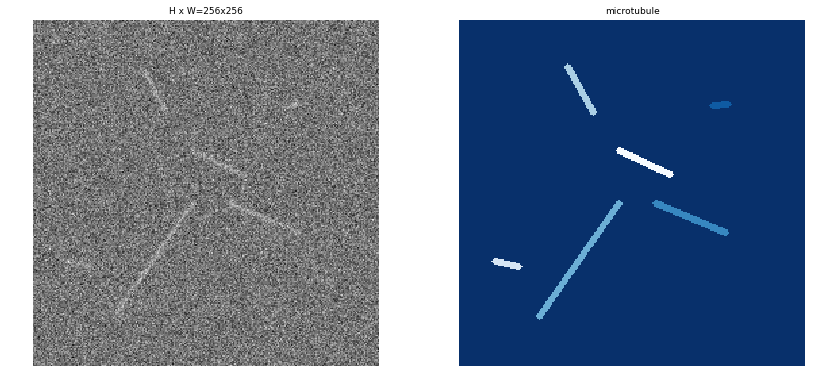

{'id': 613, 'source': 'microtubule', 'path': PosixPath('/home/hadim/local/Data/Neural_Networks/Microtubules/data/image_snr_1.1_n-mts_11_id_49.tif'), 'width': 256, 'height': 256, 'line_thickness': 4}


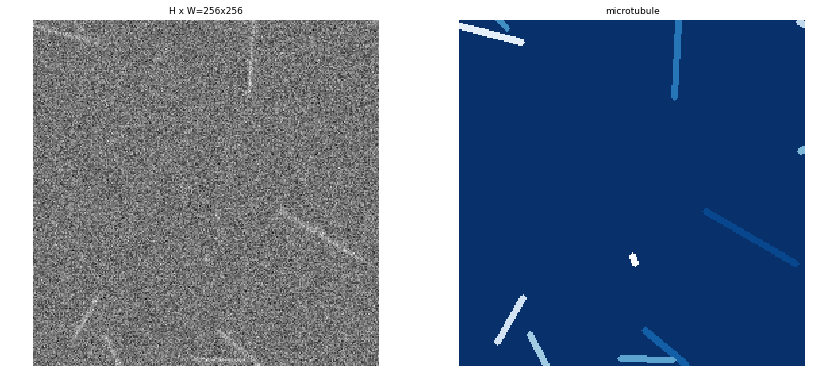

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 2, replace=True)
for image_id in image_ids:
    print(dataset.image_info[image_id])
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

# Load Model

In [12]:
class MicrotubuleConfig(Config):
    NAME = "microtubule"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # background + microtubule

    IMAGE_MIN_DIM = 10
    IMAGE_MAX_DIM = 512

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    TRAIN_ROIS_PER_IMAGE = 32
    
config = MicrotubuleConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=str(model_dir))

# Load last weights
last_model_dir = Path(model.find_last()[0])
model_candidates = sorted(list(last_model_dir.glob(f"mask_rcnn_{config.NAME}_*.h5")))
model_path = model_candidates[-1]
model.load_weights(str(model_path), by_name=True)

# Run Detection

image ID: microtubule.383 (383) 
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


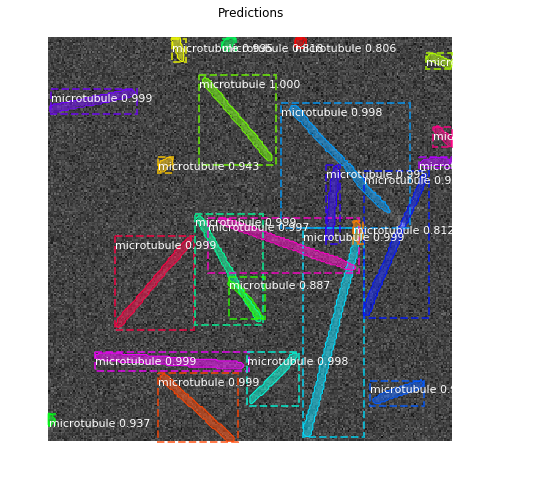

gt_class_id              shape: (21,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (21, 4)               min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 21)        min:    0.00000  max:    1.00000  bool


In [49]:
image_id = np.random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Precision recall

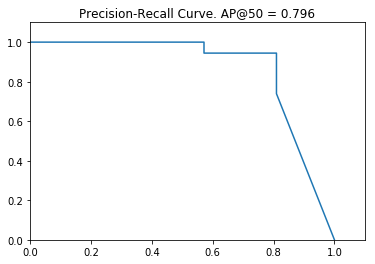

In [50]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

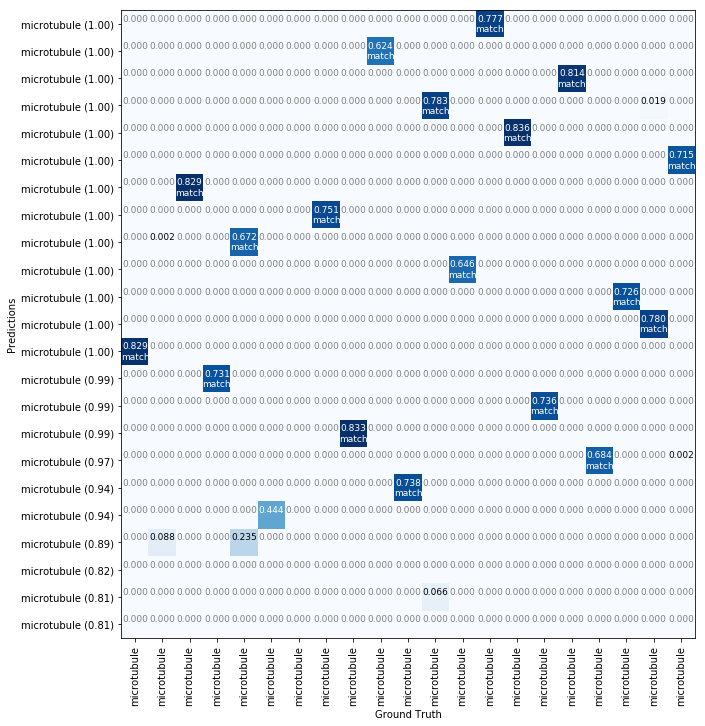

In [51]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

# Compute mAP @ IoU=50 on Batch of Images

In [52]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.668327967703


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [53]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (16368,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -4.08289  max:    3.86329  float64
positive_anchors         shape: (21, 4)               min:   -4.00000  max:  259.31371  float64
negative_anchors         shape: (235, 4)              min:  -22.62742  max:  262.62742  float64
neutral anchors          shape: (16112, 4)            min:  -90.50967  max:  282.50967  float64
refined_anchors          shape: (21, 4)               min:   -0.00000  max:  256.00000  float32


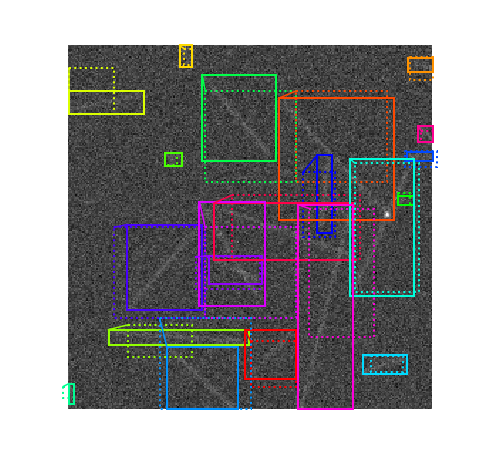

In [54]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

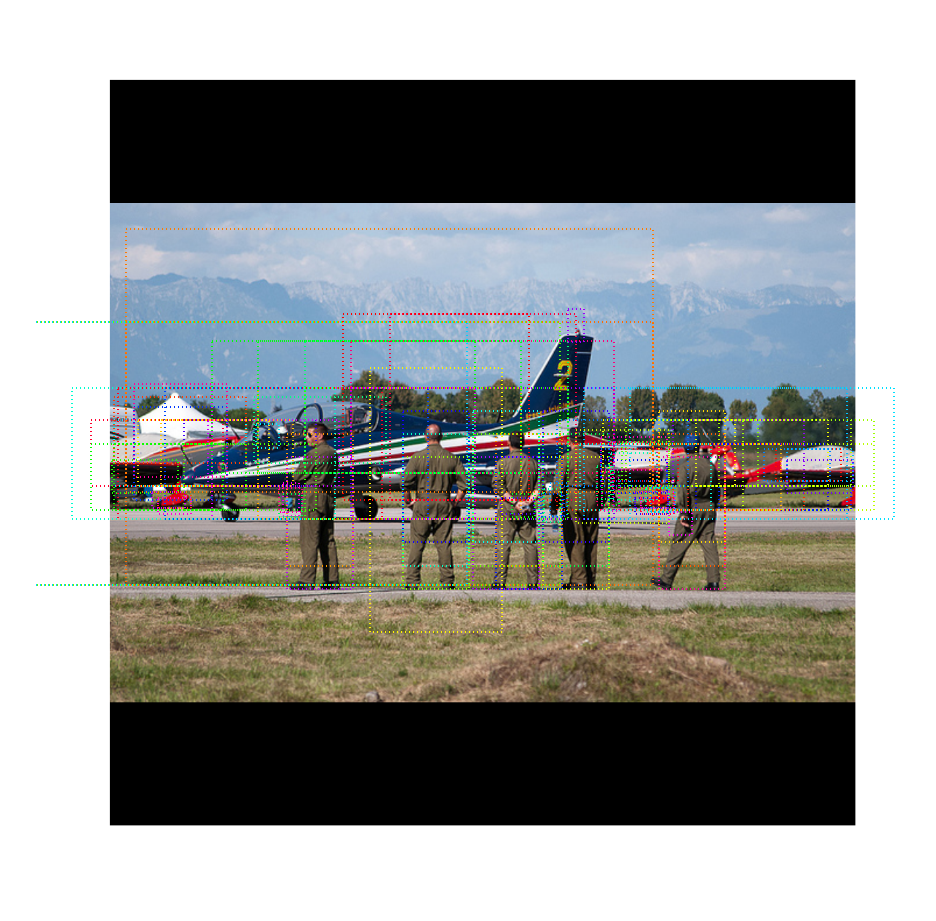

In [15]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

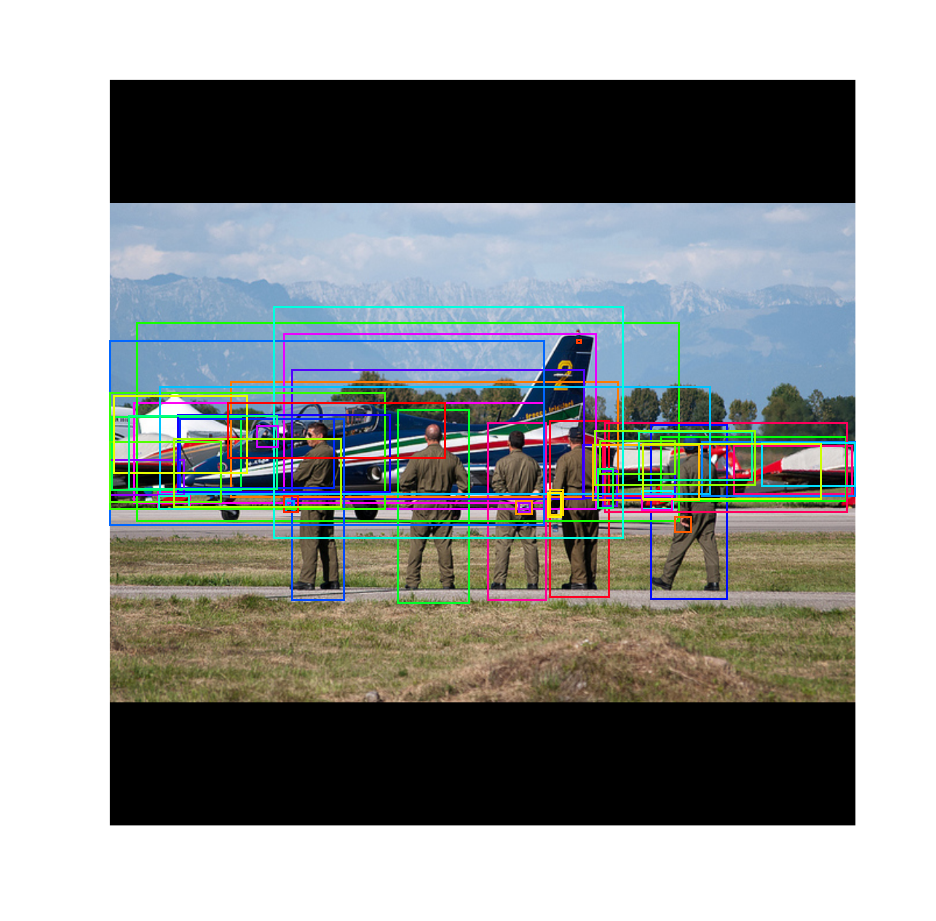

In [17]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

In [57]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

NameError: name 'rpn' is not defined

In [19]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (65472)       Recall: 0.400  Positive anchors: 8
Refined Anchors (10000)   Recall: 0.900  Positive anchors: 65
Post NMS Anchors (   50)  Recall: 0.800  Positive anchors: 9


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [59]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

InvalidArgumentError: You must feed a value for placeholder tensor 'input_anchors_2' with dtype float and shape [?,?,4]
	 [[Node: input_anchors_2 = Placeholder[dtype=DT_FLOAT, shape=[?,?,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_anchors_2', defined at:
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-03d1af65c0c8>", line 18, in <module>
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=str(model_dir))
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/mrcnn/model.py", line 1819, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/mrcnn/model.py", line 1872, in build
    input_anchors = KL.Input(shape=[None, 4], name="input_anchors")
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/engine/topology.py", line 1457, in Input
    input_tensor=tensor)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/engine/topology.py", line 1366, in __init__
    name=self.name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 507, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1777, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4521, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_anchors_2' with dtype float and shape [?,?,4]
	 [[Node: input_anchors_2 = Placeholder[dtype=DT_FLOAT, shape=[?,?,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


8 detections: ['person' 'person' 'person' 'person' 'person' 'airplane' 'airplane' 'car']


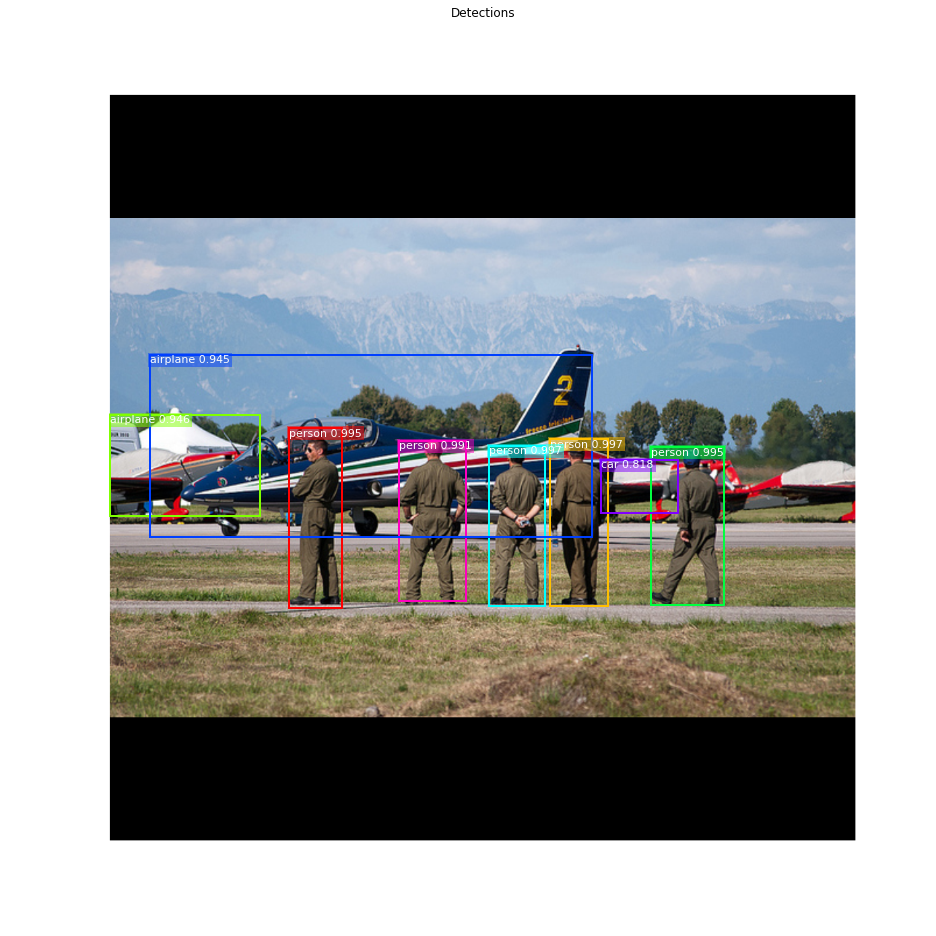

In [21]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [60]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

NameError: name 'mrcnn' is not defined

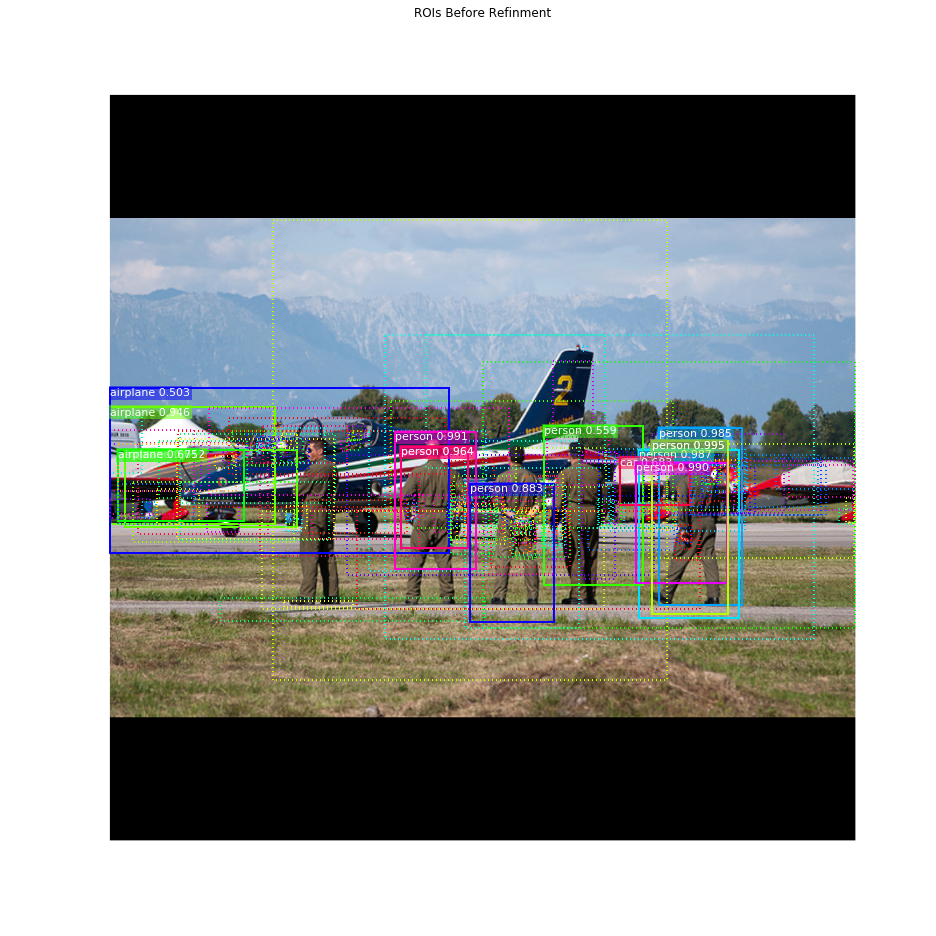

In [23]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.44748  max:    2.94838
refined_proposals        shape: (1000, 4)             min:   -8.00000  max: 1028.00000


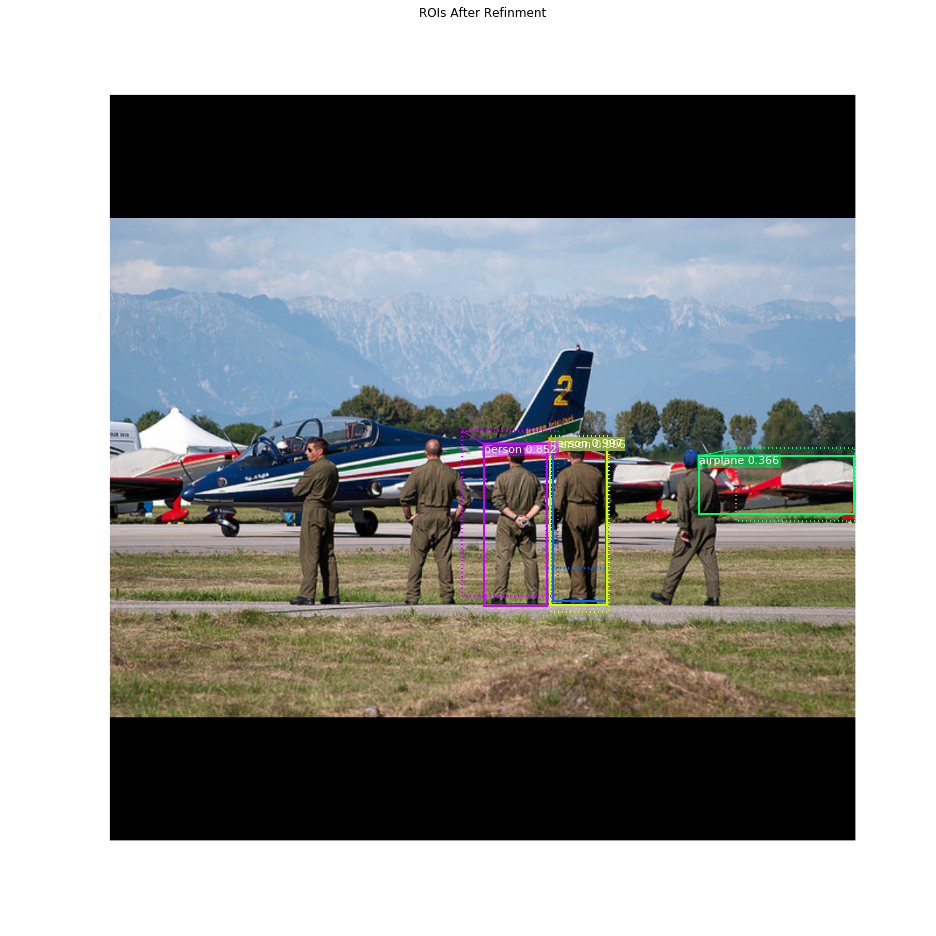

In [24]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [25]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 71 detections:
[  0   2   3   4   5   6   8   9  16  17  18  19  25  30  36  37  38  40
  42  50  51  67  68  74  78  79  92 158 162 177 187 191 209 225 261 284
 292 314 328 374 402 403 409 429 473 490 499 516 545 557 572 575 607 624
 638 639 671 703 719 744 753 754 778 790 813 815 848 862 865 876 911]


In [26]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.5 confidence. Keep 67:
[  0   2   4   5   6   8   9  16  17  18  19  25  30  36  37  38  40  42
  50  51  67  68  74  78  79 158 162 177 187 191 209 225 284 292 314 328
 374 402 403 409 429 473 490 499 516 545 557 575 607 624 638 639 671 703
 719 744 753 754 778 790 813 815 848 862 865 876 911]


#### Per-Class Non-Max Suppression

In [27]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

person                : [  0   2   5   6   9  67  68  74  79 158 162 187 191 225 284 374 403 409
 429 490 545 557 575 607 638 671 703 744 753 754 778 790 813 848 862 876
 911] -> [  0 162   9   2 671]
car                   : [ 16  18  30  36  51 177 314 328 499 624 815] -> [30]
airplane              : [  4   8  17  19  25  37  38  40  42  50  78 209 292 402 473 516 639 719
 865] -> [78 19]

Kept after per-class NMS: 8
[  0   2   9  19  30  78 162 671]


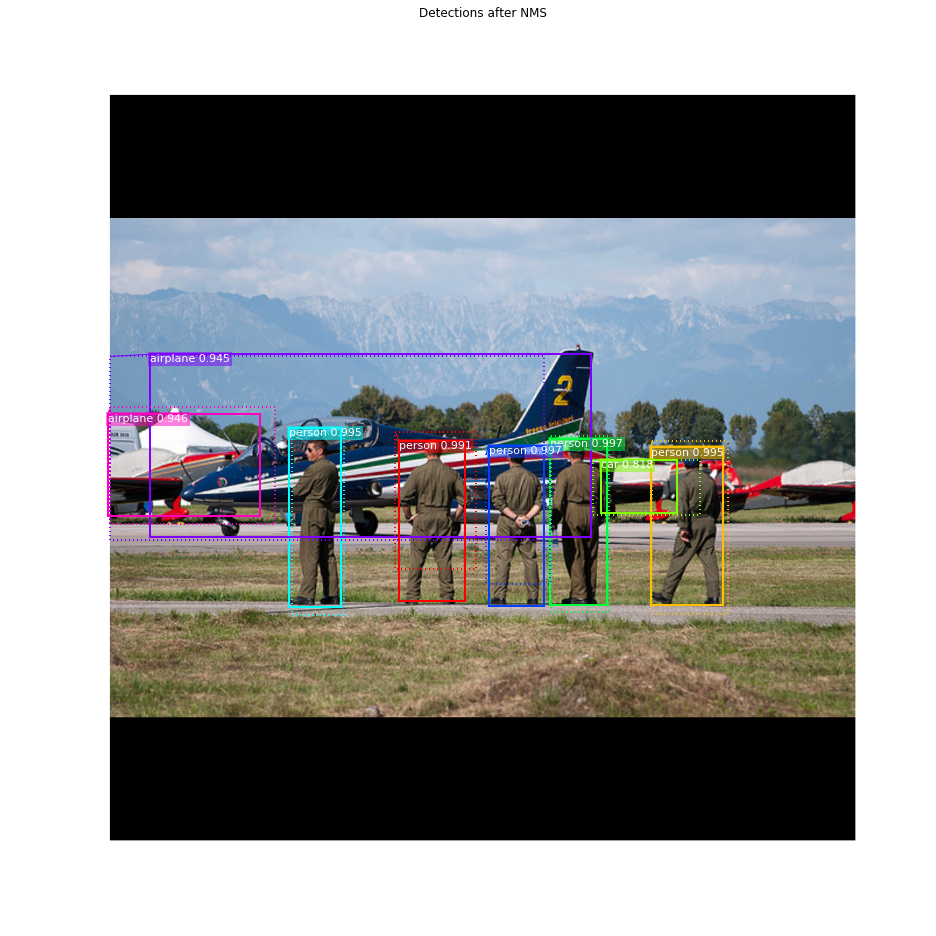

In [28]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

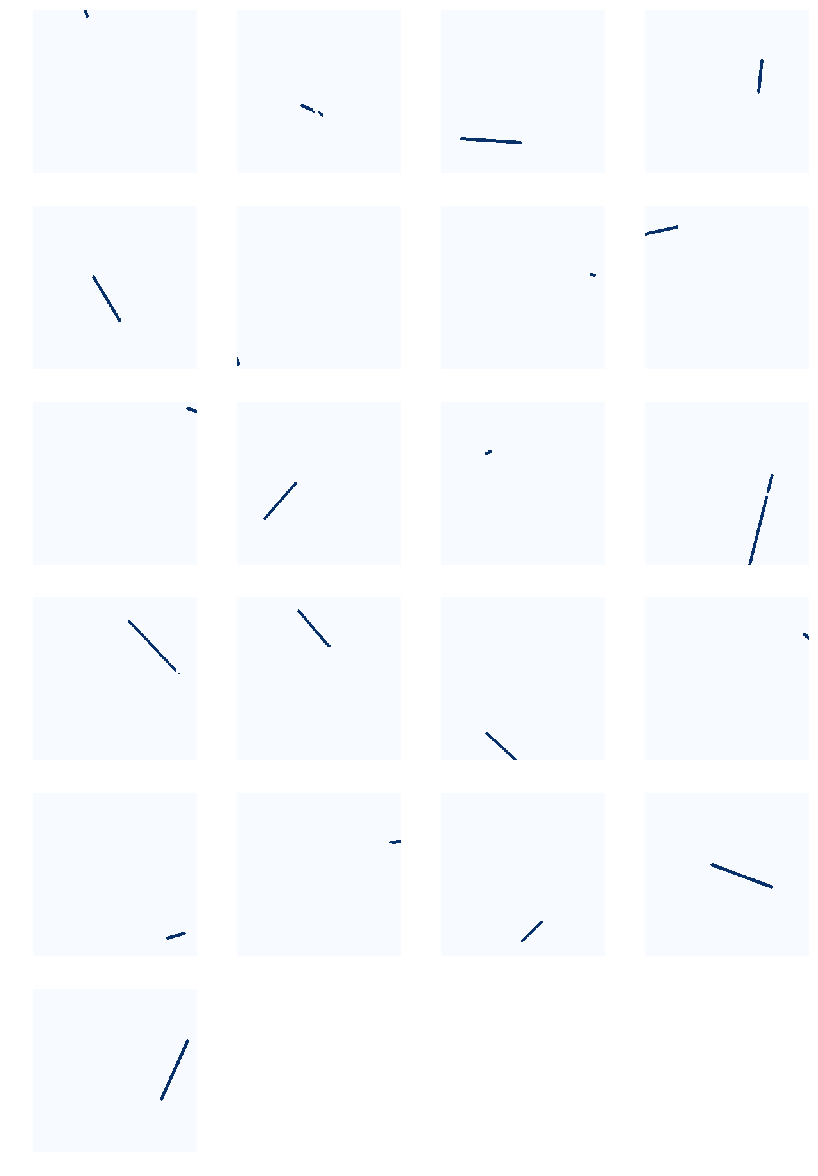

In [62]:
visualize.display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [63]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

InvalidArgumentError: You must feed a value for placeholder tensor 'input_anchors_2' with dtype float and shape [?,?,4]
	 [[Node: input_anchors_2 = Placeholder[dtype=DT_FLOAT, shape=[?,?,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_anchors_2', defined at:
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-03d1af65c0c8>", line 18, in <module>
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=str(model_dir))
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/mrcnn/model.py", line 1819, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/mrcnn/model.py", line 1872, in build
    input_anchors = KL.Input(shape=[None, 4], name="input_anchors")
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/engine/topology.py", line 1457, in Input
    input_tensor=tensor)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/engine/topology.py", line 1366, in __init__
    name=self.name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 507, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1777, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4521, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_anchors_2' with dtype float and shape [?,?,4]
	 [[Node: input_anchors_2 = Placeholder[dtype=DT_FLOAT, shape=[?,?,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [64]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

NameError: name 'mrcnn' is not defined

In [65]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

NameError: name 'display_images' is not defined

In [66]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

NameError: name 'display_images' is not defined

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [67]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

InvalidArgumentError: You must feed a value for placeholder tensor 'input_anchors_2' with dtype float and shape [?,?,4]
	 [[Node: input_anchors_2 = Placeholder[dtype=DT_FLOAT, shape=[?,?,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_anchors_2', defined at:
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-03d1af65c0c8>", line 18, in <module>
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=str(model_dir))
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/mrcnn/model.py", line 1819, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/mrcnn/model.py", line 1872, in build
    input_anchors = KL.Input(shape=[None, 4], name="input_anchors")
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/engine/topology.py", line 1457, in Input
    input_tensor=tensor)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/engine/topology.py", line 1366, in __init__
    name=self.name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 507, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1777, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4521, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_anchors_2' with dtype float and shape [?,?,4]
	 [[Node: input_anchors_2 = Placeholder[dtype=DT_FLOAT, shape=[?,?,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [68]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

NameError: name 'activations' is not defined

In [69]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

NameError: name 'display_images' is not defined

NameError: name 'activations' is not defined

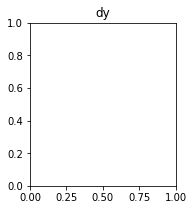

In [70]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

NameError: name 'activations' is not defined

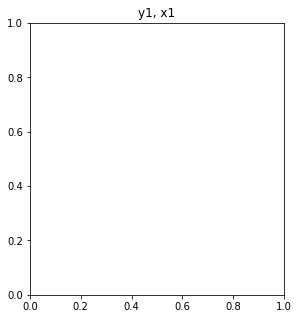

In [71]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()